In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import fsspec, os
import scipy as sp
import PIL
from PIL import Image
import random
import os
import glob
import re

In [3]:
# Define shot lists and file paths
state = 2  # state 1 -> javier, state 2 -> william, state 3 -> combined
if state == 1:
    shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,
             119661, 119662, 119663, 119665, 119666, 119667, 119669, 119670, 119671,
             119673, 119675, 119748, 119750, 119751, 119752, 119754, 119755, 119756,
             119757, 119760, 119761, 119762, 119763, 119764, 119766, 119767, 119768, 119769]
    file_path = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/Input Data/Shots/' 
    file_path_hbt = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/python_hbteplib_data/'
elif state == 2:
    shot_list = [114407,114408,114411,114412,114413,114415,114416,114417,114418,114419,114420,114422,114424,114425,114428,114429,114431,114432,114433,
                 114434,114435,114436,114438,114439,114441,114443,114444,114445,114448,114450,114451,114453,114454,114455,114456,114457,114458,114460,
                 114462,114464,114467,114468,114472,114473]
    file_path = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/Input Data/Old Shots/' 
    file_path_hbt = '//Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/oldshot_python_hbteplib_data/' 
elif state == 3:
    shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,
             119661, 119662, 119663, 119665, 119666, 119667, 119669, 119670, 119671,
             119673, 119675, 119748, 119750, 119751, 119752, 119754, 119755, 119756,
             119757, 119760, 119761, 119762, 119763, 119764, 119766, 119767, 119768, 119769,
             114407,114408,114411,114412,114413,114415,114416,114417,114418,114419,114420,114422,114424,114425,114428,114429,114431,114432,114433,
             114434,114435,114436,114438,114439,114441,114443,114444,114445,114448,114450,114451,114453,114454,114455,114456,114457,114458,114460,
             114462,114464,114467,114468,114472,114473]
    # For shots >= 119000, use Javier's paths
    # For shots < 119000, use William's paths
    def get_paths_for_shot(shot_num):
        if shot_num >= 119000:
            return ('/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/Input Data/Shots/',
                   '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/python_hbteplib_data/')
        else:
            return ('/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/Input Data/Old Shots/',
                   '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/oldshot_python_hbteplib_data/')


TARGET_FRAME_COUNT = 800
CAMERA_DEPTH = 65535.0 # 2^16
RESERVED_SHOT = 114412  # Set to a specific shot number or None for random selection

In [4]:
# Helper functions for data processing
def determine_frame_ratio(num_frames, target_frames=TARGET_FRAME_COUNT):
    """
    Determines the frame ratio needed to downsample the data to target_frames.
    Returns the ratio and the actual number of frames after downsampling.
    """
    ratio = max(1, num_frames // target_frames)
    actual_frames = num_frames // ratio
    return ratio, actual_frames

def process_shot_data(folder_path, target_frame_count, max_pixel_value, state, shot_num=None):
    """
    Process a single shot's data with automatic frame rate handling.
    Returns: 2D data (32x32), cut 2D data (32x32), and flat data for the shot
    """
    tiff_files = sorted(glob.glob(os.path.join(folder_path, "*.tiff")))
    num_frames = len(tiff_files)
    
    if num_frames == 0:
        raise ValueError(f"No TIFF files found in {folder_path}")
    
    frame_ratio, actual_frames = determine_frame_ratio(num_frames, target_frame_count)
    
    # Initialize shot lists
    flat_shot = []
    shot_2d = []
    cut_shot = []
    
    # Process TIFF files with dynamic frame ratio
    for j, tiff_file in enumerate(tiff_files):
        if j % frame_ratio == 0 and len(shot_2d) < target_frame_count:
            try:
                im = Image.open(tiff_file)
                im = np.array(im, dtype=np.float32)
                im = im / max_pixel_value
                
                # Automatically crop the center 32x32 region of the image
                h, w = im.shape
                if h < 32 or w < 32:
                    raise ValueError(f"Image too small to crop to 32x32: got {h}x{w}")

                start_h = (h - 32) // 2
                start_w = (w - 32) // 2
                cropped_im = im[start_h:start_h + 32, start_w:start_w + 32]

                
                flat_im = cropped_im.reshape(-1)  # Flatten the cropped image (32*32 = 1024)
                cut_2d = cropped_im  # cut_2d is the same as cropped_im (32x32)
                
                shot_2d.append(cropped_im)  # Store cropped image (32x32)
                flat_shot.append(flat_im)
                cut_shot.append(cut_2d)
                
            except Exception as e:
                print(f"Error loading {tiff_file}: {e}")
                continue
    
    return np.array(shot_2d), np.array(cut_shot), np.array(flat_shot)
    
def process_all_shots(shot_list, base_path, max_pixel_value, target_frame_count, state):
    """
    Process multiple shots with automatic frame rate handling
    """
    training_data_2D = []
    cut_training_data_2D = []
    flat_training_data = []
    valid_shots = []
    
    for shot in shot_list:
        if shot == RESERVED_SHOT:
            continue
        if state == 3:
            file_path, _ = get_paths_for_shot(shot)
            folder_path = os.path.join(file_path, str(shot), 'CAM-26731/tiff/')
        else:
            folder_path = os.path.join(base_path, str(shot), 'CAM-26731/tiff/')
        
        try:
            shot_2d, cut_2d, flat_data = process_shot_data(folder_path, target_frame_count, max_pixel_value, state, shot_num=shot)
            
            if len(shot_2d) == target_frame_count:
                training_data_2D.append(shot_2d)
                cut_training_data_2D.append(cut_2d)
                flat_training_data.append(flat_data)
                valid_shots.append(shot)
            else:
                print(f"Shot {shot} produced {len(shot_2d)} frames, expected {target_frame_count}. Skipping.")
                
        except Exception as e:
            print(f"Error processing shot {shot}: {e}")
            continue
    
    return (np.array(training_data_2D), 
            np.array(cut_training_data_2D), 
            np.array(flat_training_data), valid_shots)

In [5]:
# Load and format HBT data
def format_hbt_data(data, mode_num):
    # Determine frame ratio
    original_length = data[0][0].shape[0] # 5000
    target_length = TARGET_FRAME_COUNT
    frame_ratio = original_length // target_length  # generally 5 (5000/TARGET_FRAME_COUNT)
    
    data = np.asarray(data, dtype=float)
    data = np.reshape(data[:,mode_num-1,:], (len(data), original_length, 1))
    data = data[:,::frame_ratio,:]
    data = data[:,:target_length,:]
    return data

# Load HBT data
hbt_ma_data = []
hbt_mp_data = []
hbt_time_data = []
valid_shots_hbt = []
for i in range(len(shot_list)):
    shot = shot_list[i]
    if state == 3:
        _, file_path_hbt = get_paths_for_shot(shot)
    else:
        file_path_hbt = file_path_hbt
        
    try:
        ma_list = []
        mp_list = []
        for j in range(1,5):
            ma_data = np.load(os.path.join(file_path_hbt, f'{shot}m{j}Amp.npy'))
            mp_data = np.load(os.path.join(file_path_hbt, f'{shot}m{j}Phase.npy'))
            ma_list.append(ma_data)
            mp_list.append(mp_data)
        
        hbt_ma_data.append(ma_list)
        hbt_mp_data.append(mp_list)
        time_data = np.load(os.path.join(file_path_hbt, f'{shot}time.npy'))
        hbt_time_data.append(time_data)
        valid_shots_hbt.append(shot)
    except Exception as e:
        print(f"Error loading HBT data for shot {shot}: {e}")
        continue

# Format HBT data
hbt_ma1_data = format_hbt_data(hbt_ma_data, 1)
hbt_ma2_data = format_hbt_data(hbt_ma_data, 2)
hbt_ma3_data = format_hbt_data(hbt_ma_data, 3)
hbt_ma4_data = format_hbt_data(hbt_ma_data, 4)

hbt_mp1_data = format_hbt_data(hbt_mp_data, 1)
hbt_mp2_data = format_hbt_data(hbt_mp_data, 2)
hbt_mp3_data = format_hbt_data(hbt_mp_data, 3)
hbt_mp4_data = format_hbt_data(hbt_mp_data, 4)

# Format time data
hbt_time_data = np.asarray(hbt_time_data, dtype=float)
hbt_time_data = np.reshape(hbt_time_data, (len(hbt_time_data), hbt_ma_data[0][0].shape[0]))
original_length = hbt_time_data.shape[1]
frame_ratio = original_length // TARGET_FRAME_COUNT
hbt_time_data = hbt_time_data[:,::frame_ratio]
hbt_time_data = hbt_time_data[:,:TARGET_FRAME_COUNT]

print("HBT data shapes:")
print(f"Mode amplitude 1: {hbt_ma1_data.shape}")
print(f"Mode phase 1: {hbt_mp1_data.shape}")
print(f"Time data: {hbt_time_data.shape}")


# Process shot list
if state == 3:
    training_data_2D, cut_training_data_2D, flat_training_data, valid_shots = process_all_shots(shot_list, None, CAMERA_DEPTH, TARGET_FRAME_COUNT, 3)
else:
    training_data_2D, cut_training_data_2D, flat_training_data, valid_shots = process_all_shots(shot_list, file_path, CAMERA_DEPTH, TARGET_FRAME_COUNT, state)   
print(f"training_data_2D shape: {training_data_2D.shape}")
print(f"cut_training_data_2D shape: {cut_training_data_2D.shape}")

# Process RESERVED_SHOT separately for testing
reserved_shot_data_2d = None
reserved_shot_cut_2d = None
reserved_shot_flat = None
if RESERVED_SHOT is not None:
    if state == 3:
        file_path, _ = get_paths_for_shot(RESERVED_SHOT)
        folder_path = os.path.join(file_path, str(RESERVED_SHOT), 'CAM-26731/tiff/')
    else:
        folder_path = os.path.join(file_path, str(RESERVED_SHOT), 'CAM-26731/tiff/')
    
    try:
        shot_2d, cut_2d, flat_data = process_shot_data(folder_path, TARGET_FRAME_COUNT, CAMERA_DEPTH, state, shot_num=RESERVED_SHOT)
        if len(shot_2d) == TARGET_FRAME_COUNT:
            reserved_shot_data_2d = shot_2d
            reserved_shot_cut_2d = cut_2d
            reserved_shot_flat = flat_data
            print(f"Successfully processed RESERVED_SHOT {RESERVED_SHOT} with {len(shot_2d)} frames")
        else:
            print(f"RESERVED_SHOT {RESERVED_SHOT} produced {len(shot_2d)} frames, expected {TARGET_FRAME_COUNT}. Falling back to random shot.")
            RESERVED_SHOT = random.choice(valid_shots)
            folder_path = os.path.join(file_path, str(RESERVED_SHOT), 'CAM-26731/tiff/')
            shot_2d, cut_2d, flat_data = process_shot_data(folder_path, TARGET_FRAME_COUNT, CAMERA_DEPTH, state, shot_num=RESERVED_SHOT)
            reserved_shot_data_2d = shot_2d
            reserved_shot_cut_2d = cut_2d
            reserved_shot_flat = flat_data
    except Exception as e:
        print(f"Error processing RESERVED_SHOT {RESERVED_SHOT}: {e}. Falling back to random shot.")
        RESERVED_SHOT = random.choice(valid_shots)
        folder_path = os.path.join(file_path, str(RESERVED_SHOT), 'CAM-26731/tiff/')
        shot_2d, cut_2d, flat_data = process_shot_data(folder_path, TARGET_FRAME_COUNT, CAMERA_DEPTH, state, shot_num=RESERVED_SHOT)
        reserved_shot_data_2d = shot_2d
        reserved_shot_cut_2d = cut_2d
        reserved_shot_flat = flat_data

# Set RESERVED_SHOT if None
if RESERVED_SHOT is None:
    RESERVED_SHOT = random.choice(valid_shots)
    print(f"Randomly selected reserved shot: {RESERVED_SHOT}")
    if state == 3:
        file_path, _ = get_paths_for_shot(RESERVED_SHOT)
        folder_path = os.path.join(file_path, str(RESERVED_SHOT), 'CAM-26731/tiff/')
    else:
        folder_path = os.path.join(file_path, str(RESERVED_SHOT), 'CAM-26731/tiff/')
    shot_2d, cut_2d, flat_data = process_shot_data(folder_path, TARGET_FRAME_COUNT, CAMERA_DEPTH, state, shot_num=RESERVED_SHOT)
    reserved_shot_data_2d = shot_2d
    reserved_shot_cut_2d = cut_2d
    reserved_shot_flat = flat_data

HBT data shapes:
Mode amplitude 1: (44, 800, 1)
Mode phase 1: (44, 800, 1)
Time data: (44, 800)
training_data_2D shape: (43, 800, 32, 32)
cut_training_data_2D shape: (43, 800, 32, 32)
Successfully processed RESERVED_SHOT 114412 with 800 frames


Normalization factor (90th percentile): 6.32
Number of outliers (|value| > 18.97): 1
Training shape: (34200, 32, 32, 1) Target shape: (34200,)
Testing shape: (200, 32, 32, 1) Testing label shape: (200,)


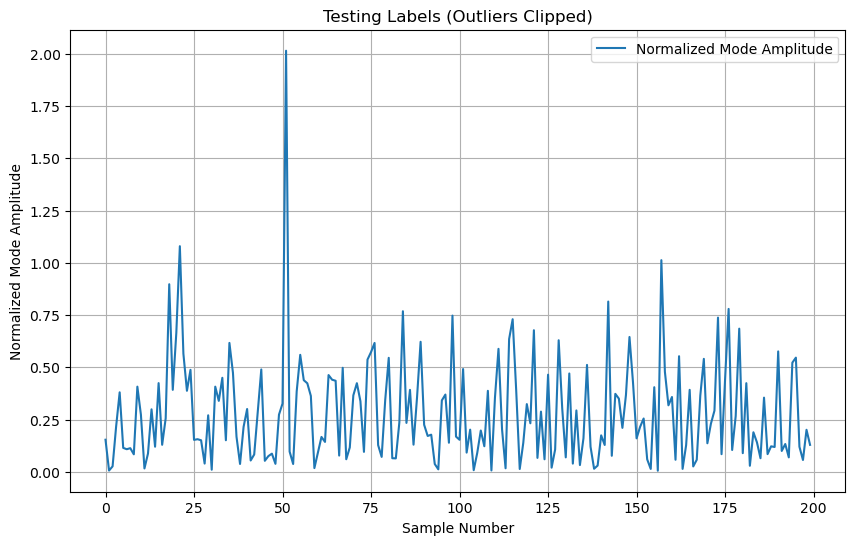

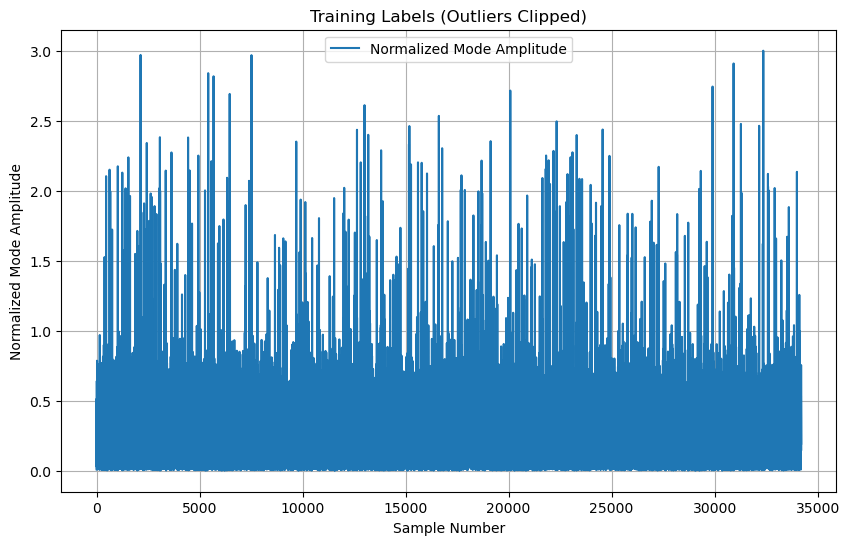

In [6]:
# Prepare data for HBT prediction model
target_data = hbt_ma2_data  # Using mode 2 amplitude as target
training_data = cut_training_data_2D

# Normalization factors
camera_norm = 1  # Camera data already normalized by max_pixel_value
# Compute ma_norm using 90th percentile to handle outliers
raw_target_vector = []
for i in range(len(valid_shots)):
    shot = valid_shots[i]
    if shot == RESERVED_SHOT:
        continue
    for j in range(len(target_data[i])):
        raw_target_vector.append(target_data[i][j])

raw_target_vector = np.asarray(raw_target_vector, dtype=np.float32)[:, 0]
percentile_90 = np.percentile(np.abs(raw_target_vector), 99)
ma_norm = percentile_90 if percentile_90 > 0 else 1.0  # Use 90th percentile for normalization
outlier_threshold = 3 * ma_norm  # Define outliers as values > 3 * normalization factor
outliers = np.abs(raw_target_vector) > outlier_threshold
print(f"Normalization factor (90th percentile): {ma_norm:.2f}")
print(f"Number of outliers (|value| > {outlier_threshold:.2f}): {np.sum(outliers)}")

# Clip outliers for normalization
raw_target_vector = np.clip(raw_target_vector, -outlier_threshold, outlier_threshold)

# Reshape the training data and labels, excluding RESERVED_SHOT
target_vector = []
training_vector = []
for i in range(len(valid_shots)):
    shot = valid_shots[i]
    if shot == RESERVED_SHOT:
        continue
    for j in range(len(target_data[i])):
        target_vector.append(target_data[i][j])
        training_vector.append(training_data[i][j])

# Shuffle the data
random.seed(123)
zip_list = list(zip(target_vector, training_vector))
random.shuffle(zip_list)
target_vector, training_vector = zip(*zip_list)

# Convert to numpy arrays and normalize with clipping
target_vector = np.asarray(target_vector, dtype=np.float32)[:, 0]
target_vector = np.clip(target_vector, -outlier_threshold, outlier_threshold) / ma_norm
training_vector = np.asarray(training_vector, dtype=np.float32).reshape(-1, 32, 32, 1)

# Split into training and testing sets
test_size = 200
testing_inputs = training_vector[-test_size:]
testing_labels = target_vector[-test_size:]
training_vector = training_vector[:-test_size]
target_vector = target_vector[:-test_size]

print('Training shape:', training_vector.shape, 'Target shape:', target_vector.shape)
print('Testing shape:', testing_inputs.shape, 'Testing label shape:', testing_labels.shape)

# Plot testing labels
plt.figure(figsize=(10, 6))
plt.plot(testing_labels, label='Normalized Mode Amplitude')
plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.title('Testing Labels (Outliers Clipped)')
plt.grid(True)
plt.legend()
plt.show()

# Plot training labels
plt.figure(figsize=(10, 6))
plt.plot(target_vector, label='Normalized Mode Amplitude')
plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.title('Training Labels (Outliers Clipped)')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
%%script true # This command stops it from running when pressing run all.
# DON'T RUN!! Single Shot. Prepare data for HBT prediction model
target_data = hbt_ma2_data  # Using mode 2 amplitude as target
training_data = cut_training_data_2D

# Normalization factors
camera_norm = 1  # Camera data already normalized by max_pixel_value
ma_norm = 1  # Mode amplitude normalization factor

# Reshape the training data and labels
target_vector = []
training_vector = []
shot = shot_list[-1]  # Select only the last shot
shot_idx = shot_list.index(shot)
for j in range(len(target_data[shot_idx])):  # Use frame count for the last shot
    target_vector.append(target_data[shot_idx][j])
    training_vector.append(training_data[-1][j])

# Shuffle the data
random.seed(123)
zip_list = list(zip(target_vector, training_vector))
#random.shuffle(zip_list)
target_vector, training_vector = zip(*zip_list)

# Convert to numpy arrays and normalize
target_vector = np.asarray(target_vector, dtype=np.float32) / ma_norm
training_vector = np.asarray(training_vector, dtype=np.float32)

# Split into training and testing sets
testing_inputs = training_vector[-201:-1]
testing_labels = target_vector[-201:-1]
training_vector = training_vector[0:-200]
target_vector = target_vector[0:-200]

print('Training shape: ', training_vector.shape, 'Target shape: ', target_vector.shape)
print('Testing shape: ', testing_inputs.shape, 'Testing label shape: ', testing_labels.shape)

# Plot testing labels for the last shot
plt.plot(testing_labels)
plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.title(f'Testing Labels for Shot {shot}')
plt.grid(True)
plt.show()

In [8]:
# Define model architecture
num_conv2d_layers = 2
num_dense_layers = 1

conv2d_neurons = [16, 16]
conv2d_size = [(8, 8), (8, 8)]
dense_layer_neurons = [10]
max_pooling_size = (4, 4)
activation_func = 'relu'
loss_func = 'mean_squared_error'
optimizer_func = 'adam'

# Create the model
william_model = tf.keras.models.Sequential()

# Add input layer
william_model.add(tf.keras.layers.InputLayer(shape=(32, 32, 1)))

# Add Conv2D layers
for i in range(num_conv2d_layers):
    william_model.add(tf.keras.layers.Conv2D(conv2d_neurons[i], conv2d_size[i], 1, activation=activation_func))
    william_model.add(tf.keras.layers.MaxPooling2D(max_pooling_size, 1))

# Flatten the output
william_model.add(tf.keras.layers.Flatten())

# Add dense layers
for i in range(num_dense_layers):
    william_model.add(tf.keras.layers.Dense(dense_layer_neurons[i], activation=activation_func))

# Output layer
william_model.add(tf.keras.layers.Dense(1))

# Compile the model
william_model.compile(optimizer=optimizer_func, loss=loss_func)

# Display model summary
william_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 15, 16)     │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        23,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,501 (158.21 KB)

 Trainable params: 40,501 (158.21 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
Model = william_model
history = Model.fit(training_vector, target_vector,
                       epochs=15,
                       validation_split=0.2,
                       verbose=1,
                       callbacks=[early_stop])

Epoch 1/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0592 - val_loss: 0.0432
Epoch 2/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0516 - val_loss: 0.0405
Epoch 3/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0451 - val_loss: 0.0416
Epoch 4/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0484 - val_loss: 0.0415
Epoch 5/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0488 - val_loss: 0.0409
Epoch 6/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0474 - val_loss: 0.0410
Epoch 7/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0459 - val_loss: 0.0397
Epoch 8/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0453 - val_loss: 0.0530
Epoch 9/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0544 - val_loss: 0.0426
Epoch 10/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0474 - val_loss: 0.0422
Epoch 11/15
855/855 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0492 - val_loss: 0.0458
Epoch 12/15
855/855 ━━━━━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


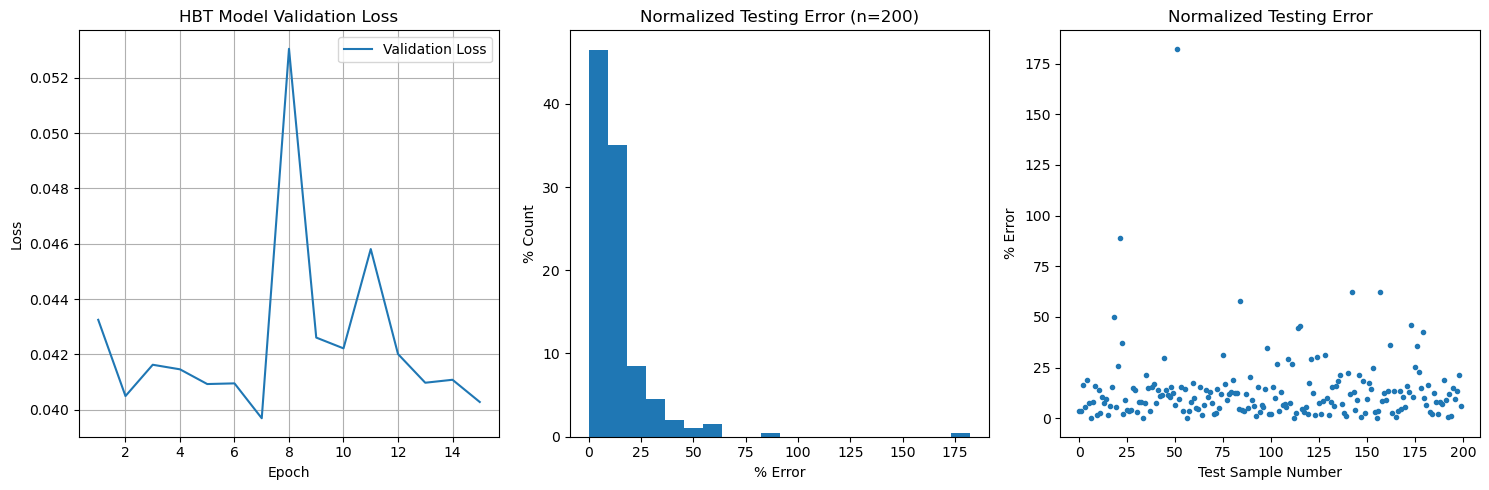

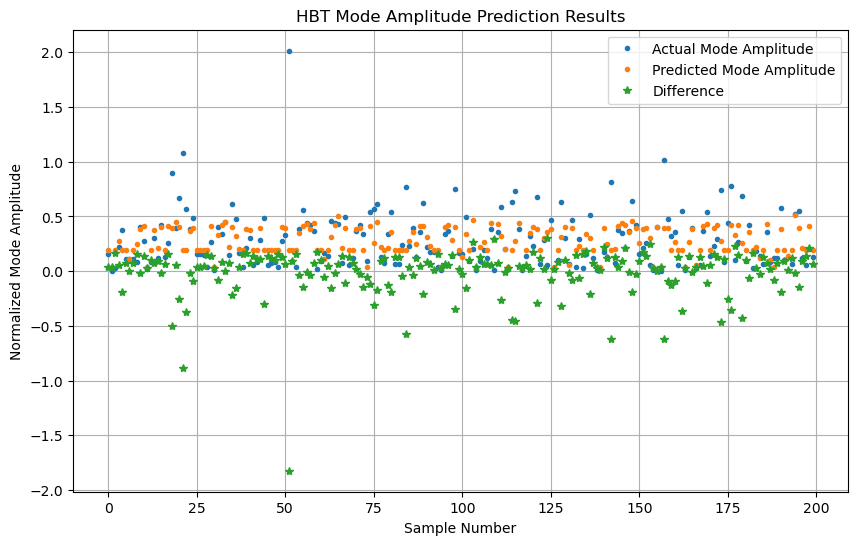

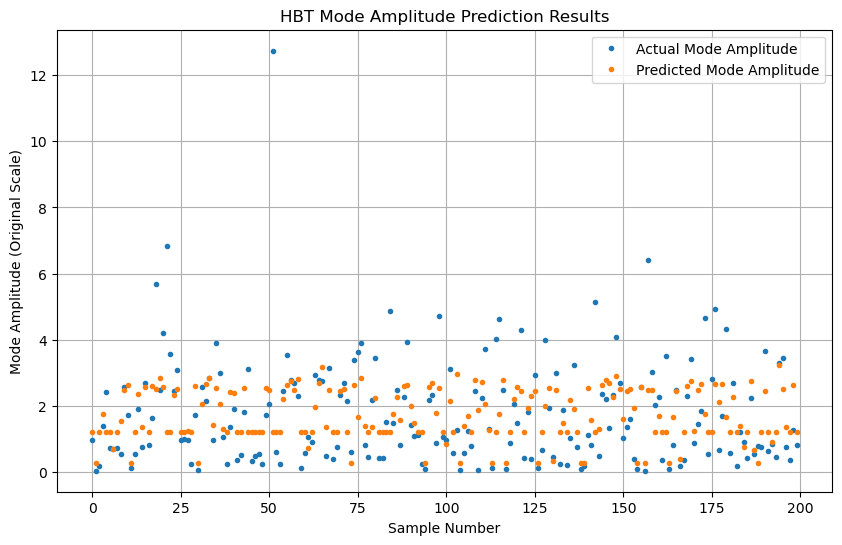

Maximum actual mode amplitude (normalized): 2.01
Maximum predicted mode amplitude (normalized): 0.51
Mean absolute percentage error: 13.60%


In [10]:
# Evaluate the model on test data
predictions = Model.predict(testing_inputs)

# Calculate prediction errors
prediction_errors = np.abs(testing_labels - predictions[:, 0]) * 100

# Create visualization plots
fig, axes = plt.subplots(figsize=(15, 5), ncols=3, nrows=1)

# Plot 1: Training History
axes[0].plot(range(1, len(history.history['val_loss']) + 1), 
             history.history['val_loss'], 
             label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('HBT Model Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Error Distribution
weights = np.ones_like(prediction_errors) / len(prediction_errors) * 100
axes[1].hist(prediction_errors, 20, weights=weights)
axes[1].set_xlabel('% Error')
axes[1].set_ylabel('% Count')
axes[1].set_title('Normalized Testing Error (n=200)')

# Plot 3: Error by Sample
axes[2].plot(prediction_errors, '.')
axes[2].set_xlabel('Test Sample Number')
axes[2].set_ylabel('% Error')
axes[2].set_title('Normalized Testing Error')

plt.tight_layout()
plt.show()

# Plot 4: Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.plot(testing_labels, '.', label='Actual Mode Amplitude')
plt.plot(predictions[:, 0], '.', label='Predicted Mode Amplitude')
plt.plot(-(testing_labels - predictions[:, 0]), '*', label='Difference')
plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.title('HBT Mode Amplitude Prediction Results')
plt.legend()
plt.grid(True)
plt.show()

# Plot original scale predictions
plt.figure(figsize=(10, 6))
plt.plot(testing_labels * ma_norm, '.', label='Actual Mode Amplitude')
plt.plot(predictions[:, 0] * ma_norm, '.', label='Predicted Mode Amplitude')
plt.xlabel('Sample Number')
plt.ylabel('Mode Amplitude (Original Scale)')
plt.title('HBT Mode Amplitude Prediction Results')
plt.legend()
plt.grid(True)
plt.show()

print(f"Maximum actual mode amplitude (normalized): {np.max(np.abs(testing_labels)):.2f}")
print(f"Maximum predicted mode amplitude (normalized): {np.max(np.abs(predictions[:, 0])):.2f}")
print(f"Mean absolute percentage error: {np.mean(prediction_errors):.2f}%")

In [11]:
# YOU MUST change name before saving!!!
#Model.save_weights('Potential Models/model_agb001.weights.h5')

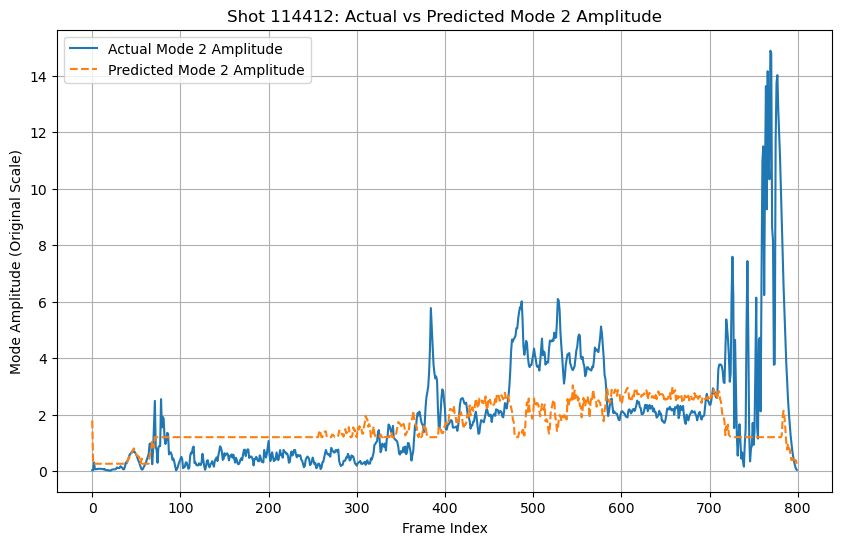

Shot 114412 - Mean absolute percentage error: 18.91%
Shot 114412 - Max actual amplitude: 14.89
Shot 114412 - Max predicted amplitude: 3.05


In [12]:
def plot_RESERVED_SHOT_predictions(shot, shot_list, cut_training_data_2d, reserved_shot_cut_2d, hbt_ma2_data, model, ma_norm):
    """Plot actual vs predicted Mode 2 amplitude for the reserved shot."""
    if reserved_shot_cut_2d is None:
        print(f"No data available for reserved shot {shot}. No plot generated.")
        return
    
    shot_idx = shot_list.index(shot)
    camera_data = reserved_shot_cut_2d
    hbt_data = hbt_ma2_data[shot_idx][:, 0]
    
    if len(camera_data) == 0:
        print(f"No camera data for shot {shot}. No plot generated.")
        return
    
    # Prepare camera data for prediction
    input_data = np.array(camera_data).reshape(-1, 32, 32, 1)
    predictions = model.predict(input_data, verbose=0)[:, 0] * ma_norm  # Scale back to original units
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(hbt_data, label='Actual Mode 2 Amplitude')
    plt.plot(predictions, '--', label='Predicted Mode 2 Amplitude')
    plt.xlabel('Frame Index')
    plt.ylabel('Mode Amplitude (Original Scale)')
    plt.title(f'Shot {shot}: Actual vs Predicted Mode 2 Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print metrics
    prediction_errors = np.abs(hbt_data - predictions) / ma_norm * 100
    print(f"Shot {shot} - Mean absolute percentage error: {np.mean(prediction_errors):.2f}%")
    print(f"Shot {shot} - Max actual amplitude: {np.max(np.abs(hbt_data)):.2f}")
    print(f"Shot {shot} - Max predicted amplitude: {np.max(np.abs(predictions)):.2f}")

# Plot predictions for the reserved shot
plot_RESERVED_SHOT_predictions(
    RESERVED_SHOT, shot_list, cut_training_data_2D, reserved_shot_cut_2d, hbt_ma2_data, william_model, ma_norm
)